# SENSE and Noise
Here we show SENSE reconstruction for comparison



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mrsigpy as mrs
from scipy import signal as sig

%matplotlib inline

Nx = 256     # Number of pixels along x
Nc = 2       # Number of coils (channels)
x = np.arange(Nx)  # Position in "image"

## Signal
We create a simple 1D signal that consists of a triangle and a half-circle.  This approach could be used with 2D images similarly.



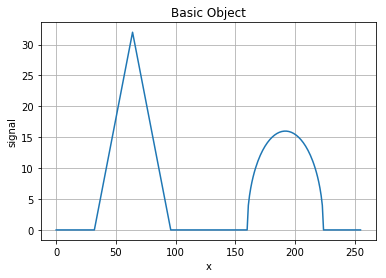

In [2]:
# Create Signal - for next parts

m = np.zeros(Nx)
m[Nx//8:Nx//4]=np.arange(0,Nx/8)       #Ramp up
m[np.int(Nx/4):np.int(3*Nx/8)]=np.arange(Nx/8,0,-1)  #Ramp down
scirc = np.arange(-Nx/8,Nx/8,1)
scirc = np.sqrt(np.power((Nx/8),2)-scirc*scirc)/2      #Semi-circle, half amplitude
m[np.int(5.* Nx/8):np.int(7.* Nx/8)] = scirc   
m = np.expand_dims(m,axis=1)

# -- Flat image instead?
#m = np.ones((Nx,1))*20.0
#m[0:5] = 0
#m[Nx-5:] = 0

plt.plot(x,m)
mrs.lplot('x','signal','Basic Object')

Now calculate coil sensitivities.  For now we will have 2 coils with gaussian sensitvity profiles.  We will use a $N_c \times 1$ matrix $C$ at each pixel to express sensitivities of channels.

/Users/brian/anaconda3/lib/python3.7/site-packages/numpy/core/numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


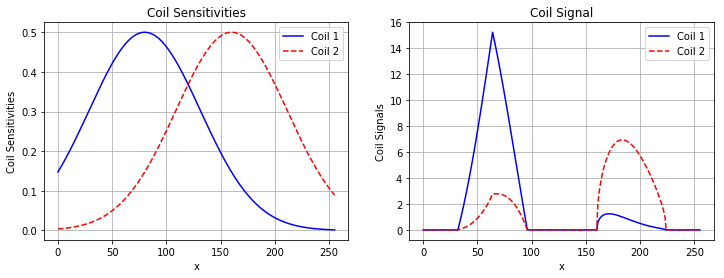

In [3]:
# -- Make gaussian sensitivities (C), about evenly spaced
csens = np.zeros((Nx,Nc),dtype='complex64')
for c in range(0,Nc):
  csens[:,c] = mrs.gaussian(x,(1.0/(Nc+1.2)*(c+1)*Nx),Nx/(2.5*Nc))
# --Normalized to 0.5 for illustration (not necessary!)
csens = csens / np.max(csens[:])*.5  

# -- Construct Coil Signals (S)
csignals = csens * m    

# -- Plot Sensitivities and Signals
fig = plt.figure(figsize=(12.,4.))
plt.subplot(1,2,1)
plt.plot(x,csens[:,0],'b-',label='Coil 1')
plt.plot(x,csens[:,1],'r--',label='Coil 2')
mrs.lplot('x','Coil Sensitivities','Coil Sensitivities',legend=True)

plt.subplot(1,2,2)
plt.plot(x,csignals[:,0],'b-',label='Coil 1')
plt.plot(x,csignals[:,1],'r--',label='Coil 2')
mrs.lplot('x','Coil Signals','Coil Signal',legend=True)


## SENSE Formulation
For each pixel with $N_c$ channels and a reduction factor $R$, we assume we have an $N_c \times R$ signal $S_{ij}$, where $i \le N_c$ is the channel, and $j \le R$ are aliased pixels.  

We calculate the sense weights (at each pixel) as a $R \times N_c$ matrix $W_{ij}$.  Specifically $W$ is defined from Pruessmann Eq. 2 as:

$W = (C^H \Psi^{-1} C)^{-1} C^H \Psi^{-1}$

where $C$ is the $N_c \times R$ sensitivity of coils at aliased pixels and $\Psi$ is the ($N_c \times N_c$) noise covariance matrix.

The reconstructed signal (at each pixel) will be $\hat{M} = WS$, where M is a column of unaliased pixels.




## Example 1:  Orthogonal Sensitivities
We are considering R=2 with 2 aliased pixels.  Here the sensitivities are orthogonal and each only sensitive to one aliased pixel, one twice as sensitive as the other.  
1. What are the SENSE weights?
2. What is the g factor?
3. What is the output noise at each pixel (Remember, R=2!)

In [9]:
# 1. Orthogonal Coil Sensitivities
print("-- Example 1:  Orthogonal Coils")
Psi = np.eye(2)
S = np.array([[1,0],[0,0.5]])
#S = np.array([[1,0.5],[-.5,1]])  # -- Still Orthogonal, but equal magnitude and rotated.
(W,gfact,calcnoise) = mrs.senseweights(S,Psi,gfactorcalc=True,noisecalc=True)
print("Sensitivities",S)
print("Weights",W)
print("g-factor",gfact)
print("calculated noise",calcnoise)

-- Example 1:  Orthogonal Coils
SENSE Weight Calc - 1 pts, 2 coils, R=2
Sensitivities [[ 1.   0.5]
 [-0.5  1. ]]
Weights [[ 0.8+0.j -0.4+0.j]
 [ 0.4+0.j  0.8+0.j]]
g-factor [1. 1.]
calculated noise [1.26491106 1.26491106]


### Results
Note that the g-factor is 1 (perfect inversion).  The noise is effectively amplified by $\sqrt{2}$ for the first pixel because R=2, and by 2$\sqrt{2}$ for the second since the weight is 2$\times$ higher.

Try changing the sensitivity to $\left[ \begin{matrix} 1 &0.5 \\ -0.5 & 1.0    \end{matrix} \right]$

## Example 2
Now the sensitivities are not orthogonal.  How do things change?

In [12]:
# 2. Non-Orthogonal Sensitivities
print("-- Example 2:  Non-Orthogonal Coils")
Psi = np.eye(2)
S = np.array([[1,0.5],[0,0.5]])
(W,gfact,calcnoise) = mrs.senseweights(S,Psi,gfactorcalc=True,noisecalc=True)
print("Sensitivities",S)
print("Weights",W)
print("g-factor",gfact)
print("calculated noise",calcnoise)


-- Example 2:  Non-Orthogonal Coils
SENSE Weight Calc - 1 pts, 2 coils, R=2
Sensitivities [[1.  0.5]
 [0.  0.5]]
Weights [[ 1.+0.j -1.+0.j]
 [ 0.+0.j  2.+0.j]]
g-factor [1.41421356 1.41421356]
calculated noise [2.         2.82842712]


## R=1 SENSE
With no acceleration, the sensitivity calculation will emphasize the coil that has the best sensitivity at a given location.

SENSE Weight Calc - 256 pts, 2 coils, R=1
Size of weights is  (256, 1, 2)
Size of reconstructed signal is  (256, 1)


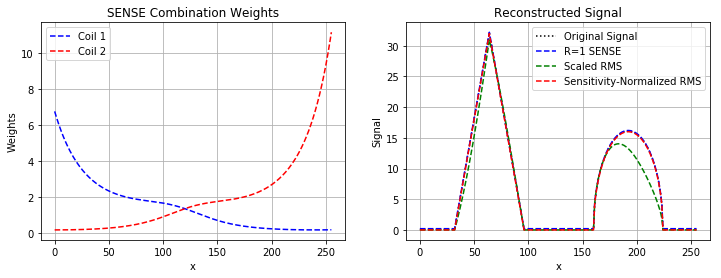

In [5]:
# Add dimension with 1 for R=1 (SENSE needs this to identify R)
csensR1 = np.expand_dims(np.squeeze(csens),axis=2)    # N x 2 x 1
cov = np.eye(Nc)  # Noise covariance

(cweights,gfactor,noiseR1) = mrs.senseweights(csensR1,noisecov=cov,gfactorcalc=True,noisecalc=True)
print("Size of weights is ",cweights.shape)

sensesig = mrs.senserecon(csignals,cweights)
print("Size of reconstructed signal is ",sensesig.shape)

rmssig = mrs.rmscombine(csignals) * 2
normrmssig = mrs.rmscombine(csignals,csensR1)

fig = plt.figure(figsize=(12.,4.))

plt.subplot(1,2,1)
plt.plot(x,cweights[:,0,0],'b--',label='Coil 1')  # small delta show trace
plt.plot(x,cweights[:,0,1],'r--',label='Coil 2')  # small delta show trace
mrs.lplot('x','Weights','SENSE Combination Weights',legend=True)

plt.subplot(1,2,2)
plt.plot(x,m+.1,'k:',label='Original Signal')  # small delta show trace
plt.plot(x,sensesig+.2,'b--',label='R=1 SENSE')
plt.plot(x,rmssig,'g--',label='Scaled RMS')
plt.plot(x,normrmssig,'r--',label='Sensitivity-Normalized RMS')
mrs.lplot('x','Signal','Reconstructed Signal',legend=True)

## Results
### Sensitivities
We normalized the sensitivities to 0.5.  In the region where the sensitivity peaks (about 25% and 75% across) the active coil has a weight of 2, as expected.  At the left/right edges, the coil with zero-sensitivity has a weight of zero as expected.
### Image
Note that the SENSE combination reconstructs the signal perfectly.  If we know the coil sensitivities, so does the sensitivity-normalized RMS.  (These will differ with noise...)  Without sensitivities, the RMS has a "shading" as here there is a constant scale just for comparison.



## Addition of Noise
Now we will add noise to the signals and repeat the reconstruction.

Since the reconstructed signal is $\hat{M} = WS$, we can see that gaussian noise in the individual channels will remain gaussian in the final image, usually correlated between unaliased pixels.


Specifically, the covariance of noise at unaliased pixels is given by  $W \psi W^H$.  

Expending, $W \psi W^H = (C^H \Psi^{-1} C)^{-1} C^H \Psi^{-1} \Psi \Psi^{-1} C (C^H \Psi^{-1} C)^{-1} $

The $\Psi$ and $\Psi^{-1}$ terms in the middle cancel, then the expression $(C^H \Psi^{-1} C)^{-1} C^H \Psi^{-1} C$ gives identity.  Therefore the noise covariance is $(C^H \Psi^{-1} C)^{-1} $

It follows that the image standard deviation at a pixel i is $\sqrt{[(C^H \Psi^{-1} C)^{-1}]_{i,i}}$

Size of cnoise is  (256, 2)
Size of reconstructed signal is  (256, 1)


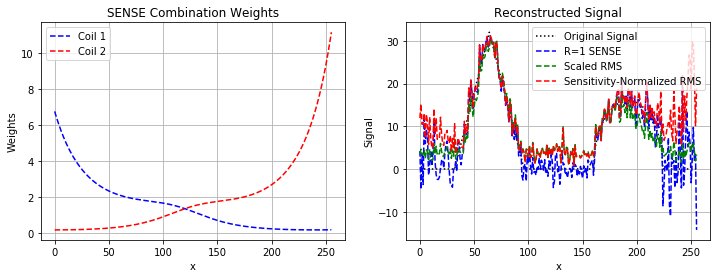

In [6]:
# -- Generate Multivariate noise
cnoise = np.random.multivariate_normal(np.zeros(Nc),cov,(Nx)) + 1j*np.random.multivariate_normal(np.zeros(Nc),cov,(Nx))
print("Size of cnoise is ",cnoise.shape)

# -- Add noise!
cnoisysignals = csignals + cnoise

# -- SENSE Reconstruction
sensesig = mrs.senserecon(cnoisysignals,cweights)
print("Size of reconstructed signal is ",sensesig.shape)

# -- RMS Reconstruction
rmssig = mrs.rmscombine(cnoisysignals) * 2  # 2 is scale factor
normrmssig = mrs.rmscombine(cnoisysignals,csens)

fig = plt.figure(figsize=(12.,4.))

plt.subplot(1,2,1)
plt.plot(x,cweights[:,0,0],'b--',label='Coil 1')  # small delta show trace
plt.plot(x,cweights[:,0,1],'r--',label='Coil 2')  # small delta show trace
mrs.lplot('x','Weights','SENSE Combination Weights')
plt.legend()

plt.subplot(1,2,2)
plt.plot(x,m,'k:',label='Original Signal')  # small delta show trace
plt.plot(x,sensesig,'b--',label='R=1 SENSE')
plt.plot(x,rmssig,'g--',label='Scaled RMS')
plt.plot(x,normrmssig,'r--',label='Sensitivity-Normalized RMS')
mrs.lplot('x','Signal','Reconstructed Signal')
plt.legend()

## Results 
The reconstruction has noise!  The SENSE noise is worse where the combination weights are higher (not surprising!).  The RMS combination has a bias, whereas SENSE does not (middle).  Finally, the normalized RMS amplifies noise in areas of lower coil sensitivity (left and right).



## R=2 SENSE
Now we will undersample and use SENSE to unalias the data.

SENSE Weight Calc - 128 pts, 2 coils, R=2
Size of weights is  (128, 2, 2)
Size of weights to plot is  (256, 2)
Size of reconstructed signal is  (128, 2)


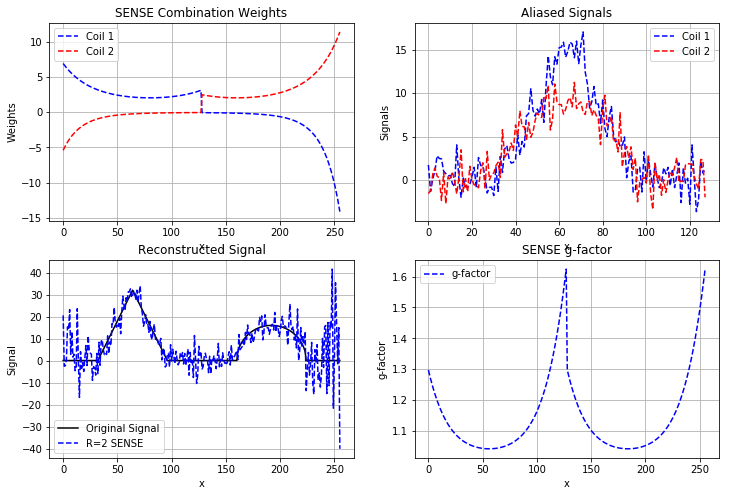

In [7]:
# Modify coil sensitivities for R=1
csensR2 = np.expand_dims(np.squeeze(csens),axis=2)    
# Nx x 2coils x 1 --> Nx/2 x 2coils x R=2
halfNx = np.int(Nx/2)
halfx = x[0:halfNx]
csensR2 = np.concatenate((csensR2[0:halfNx,:,:],csensR2[halfNx:,:,:]),axis=2)


(cweightsR2,gfactorR2,noiseR2) = mrs.senseweights(csensR2,noisecov=cov,gfactorcalc=True,noisecalc=True)
print("Size of weights is ",cweightsR2.shape)
# Organize weights for plot.
cweightsplt = np.reshape(cweightsR2,(Nx,2),order='F')  
cweightsplt = np.squeeze(cweightsplt)
print("Size of weights to plot is ",cweightsplt.shape)
gfactorplt = np.reshape(gfactorR2,(Nx,1),order='F')
noiseR2 = np.reshape(noiseR2,(Nx,1),order='F')


# Alias the signals
csignalsR2 = cnoisysignals[0:halfNx,:]+cnoisysignals[halfNx:,:]

#cweights = np.ones((halfNx,2,2))  # -- Just alias signals for testing!
sensesig = mrs.senserecon(csignalsR2,cweightsR2)
print("Size of reconstructed signal is ",sensesig.shape)
sensesig = np.reshape(sensesig,(Nx,-1),order='F')  
#sensesig = np.concatenate((sensesig[:,0],sensesig[:,1]),axis=0)

fig = plt.figure(figsize=(12.,8.))

plt.subplot(2,2,1)
plt.plot(x,cweightsplt[:,0],'b--',label='Coil 1')  # small delta show trace
plt.plot(x,cweightsplt[:,1],'r--',label='Coil 2')  # small delta show trace
mrs.lplot('x','Weights','SENSE Combination Weights',legend=True)

plt.subplot(2,2,2)
plt.plot(halfx,csignalsR2[:,0],'b--',label='Coil 1')  # small delta show trace
plt.plot(halfx,csignalsR2[:,1],'r--',label='Coil 2')  # small delta show trace
mrs.lplot('x','Signals','Aliased Signals',legend=True)

plt.subplot(2,2,3)
plt.plot(x,m+.1,'k-',label='Original Signal')  # small delta show trace
plt.plot(x,sensesig+.2,'b--',label='R=2 SENSE')
mrs.lplot('x','Signal','Reconstructed Signal',legend=True)

plt.subplot(2,2,4)
plt.plot(x,gfactorplt,'b--',label='g-factor')
mrs.lplot('x','g-factor','SENSE g-factor',legend=True)





### SENSE Noise
Because noise in SENSE is additive, we can reconstruct only the noise, and plot it.  As expected it is higher at the edges for R=1.  For R=1 it also peaks in the middle, and is periodic.  

We can predict the noise from SENSE in two ways.  
1. Directly calculate noise using the sensitivity matrix - available in the function senseweights()
2. Do a _multiple noise propagation_ approach, where repeated reconstructions are performed and the statistics at each pixel are measured.


### G-factor
The g-factor tells us about noise amplification due to using coils to unalias signal, but in the case of R=1 SENSE, the g-factor is 1.



/Users/brian/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  del sys.path[0]
/Users/brian/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part


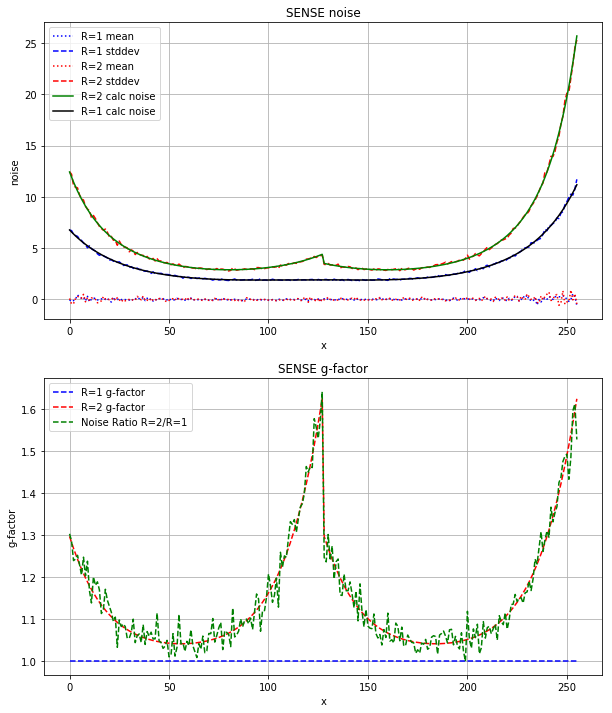

In [8]:
# -- Generate Multivariate noise
Nnoise = 1000  # repetitions of recon for noise calculation
cnoise = np.random.multivariate_normal(np.zeros(2),cov,(Nx*Nnoise)) + 1j*np.random.multivariate_normal(np.zeros(2),cov,(Nx*Nnoise))
cnoise = np.reshape(cnoise,(Nx,2,Nnoise),order='F')  # Nx x Nc x Nnoise

# -- Allocate arrays to accumulate repeated recunstructions
sigR1 = np.zeros((Nx,Nnoise))
sigR2 = np.zeros((Nx,Nnoise))

for n in range(Nnoise):
  # -- SENSE Reconstruction of noise only!
  sensesig = mrs.senserecon(cnoise[:,:,n],cweights)
  sigR1[:,n] = np.squeeze(sensesig)

  # -- For R=2, just use half the pixels of noise
  # -- If you aliased the pixels you'd get sqrt(R) increase in noise here!
  #sensesigR2 = mrs.senserecon(cnoise[0:halfNx,:,n],cweightsR2)                       #Only using half
  sensesigR2 = mrs.senserecon(cnoise[0:halfNx,:,n]+cnoise[halfNx:Nx,:,n],cweightsR2)  #Aliased pixels
  # -- Reshape to image size.
  sensesigR2 = np.reshape(sensesigR2,(Nx,1),order='F')
  sigR2[:,n] = np.squeeze(sensesigR2)
 
# -- Calculate mean / standard deviations of repeated reconstructions
sigR1mean = np.mean(sigR1,axis=1)
sigR1std = np.std(sigR1,axis=1)
sigR2mean = np.mean(sigR2,axis=1)
sigR2std = np.std(sigR2,axis=1)

# -- Ratio of standard deviations as "experimental g-factor"
# -- Note: g-factor refers to geometry/unaliasing, NOT sqrt(R) so correction here:
gfactexp = sigR2std / sigR1std / np.sqrt(2)

# -- PLOT RESULTS
fig = plt.figure(figsize=(10.,12.))
plt.subplot(2,1,1)
plt.plot(x,sigR1mean,'b:',label='R=1 mean')  # small delta show trace
plt.plot(x,sigR1std,'b--',label='R=1 stddev')  # small delta show trace
plt.plot(x,sigR2mean,'r:',label='R=2 mean')  # small delta show trace
plt.plot(x,sigR2std,'r--',label='R=2 stddev')  # small delta show trace
plt.plot(x,noiseR2,'g-',label='R=2 calc noise')
plt.plot(x,noiseR1,'k-',label='R=1 calc noise')

mrs.lplot('x','noise','SENSE noise',legend=True)

plt.subplot(2,1,2)
plt.plot(x,gfactor,'b--',label='R=1 g-factor')  # small delta show trace
plt.plot(x,gfactorplt,'r--',label='R=2 g-factor')  # small delta show trace
plt.plot(x,gfactexp,'g--',label='Noise Ratio R=2/R=1')
mrs.lplot('x','g-factor','SENSE g-factor',legend=True)



## Results
Noise is greater at the edges due to coil sensitivity dropoff.  g-factor is periodic.  Noise calculation by multiple propagation agrees very well with direct noise calculation, as well as g-factor for comparing R=1 to R=2.

Note that the noise is completely independent of the object - again this is because the coil combination is linear, though also that the noise is calculated along with the weights (before we have any data!)




## TO DO HERE
1. Make number of coils a variable throughout
